In [21]:
import pandas as pd

df = pd.read_csv('merged_with_age.csv')
df.head()

,patientunitstayid,heartrate_hour0,heartrate_hour1,heartrate_hour2,heartrate_hour3,heartrate_max_hour0,heartrate_max_hour1,heartrate_max_hour2,heartrate_max_hour3,heartrate_min_hour0,...,sodium_min,sodium_max,sodium_mean,potassium_min,potassium_max,potassium_mean,total bilirubin_min,total bilirubin_max,total bilirubin_mean,age
0,141515.0,87.431579,103.103448,85.381443,82.879121,94.0,136.0,134.0,90.0,80.0,...,132.000000,148.000000,142.380364,3.1,4.4,3.652841,1.0000,1.4,1.200000,68
1,141751.0,107.436782,105.606742,112.012048,106.170213,137.0,116.0,120.0,117.0,93.0,...,127.000000,146.000000,140.545849,2.8,4.0,3.494092,0.5000,1.3,0.900000,60
2,142173.0,74.104651,76.390244,81.367089,75.818182,86.0,100.0,96.0,89.0,68.0,...,134.000000,143.000000,138.668909,2.8,4.1,3.614395,0.3000,0.6,0.457466,59
3,142483.0,77.108108,90.075949,75.208333,77.270833,100.0,108.0,92.0,92.0,60.0,...,135.000000,151.000000,144.995126,3.1,4.4,3.756931,0.3306,1.4,0.639059,68
4,142636.0,78.446429,69.614583,69.142857,67.926829,132.0,106.0,92.0,86.0,64.0,...,134.827127,144.121856,140.929783,3.5,5.0,4.396852,0.2000,0.2,0.200000,55


In [22]:
# select patient with actualicumortality = 1
patient_alive = df[df['actualicumortality'] == 1]
alive_id = patient_alive['patientunitstayid'].unique()

# select patient with actualicumortality = 0
patient_dead = df[df['actualicumortality'] == 0]
dead_id = patient_dead['patientunitstayid'].unique()
print(len(alive_id))
print(len(dead_id))

5695
1010


In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
m = 20
# random shuffle the dead_id and alive_id
np.random.shuffle(dead_id)
np.random.shuffle(alive_id)

# make sure the alive_id is not longer than dead_id
alive_id = alive_id[:len(dead_id)]

# train_test_split and maintain the ratio of dead & alive
train_size = 0.8
test_size = 0.2
test_data_dict = {}
train_data_dict = {}
for i in range(1,m):
    dead_train, dead_test = train_test_split(dead_id, test_size=test_size,random_state=i)
    alive_train, alive_test = train_test_split(alive_id, test_size=test_size,random_state=i)
    train_ids = np.concatenate((dead_train, alive_train))
    train_data = df[df['patientunitstayid'].isin(train_ids)]
    test_ids = np.concatenate((dead_test, alive_test))
    test_data = df[df['patientunitstayid'].isin(test_ids)]
    test_data_dict[i] = test_data
    train_data_dict[i] = train_data

In [24]:
X_train={}
y_train={}
X_test={}
y_test={}
for i in range(1,m):
    X_train[i] = train_data_dict[i].drop(['actualicumortality', 'patientunitstayid'], axis=1)
    y_train[i] = train_data_dict[i]['actualicumortality']
    X_test[i] = test_data_dict[i].drop(['actualicumortality', 'patientunitstayid'], axis=1)
    y_test[i] = test_data_dict[i]['actualicumortality']

    # normalize
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train[i] = scaler.fit_transform(X_train[i])
    X_test[i] = scaler.transform(X_test[i])

accuracy: 78.87%
confusion_matrix: 
[[3008  830]
 [ 792 3046]]
classification_report: 
              precision    recall  f1-score   support

           0     0.7916    0.7837    0.7876      3838
           1     0.7859    0.7936    0.7897      3838

    accuracy                         0.7887      7676
   macro avg     0.7887    0.7887    0.7887      7676
weighted avg     0.7887    0.7887    0.7887      7676

roc_auc: 0.7886920270974466


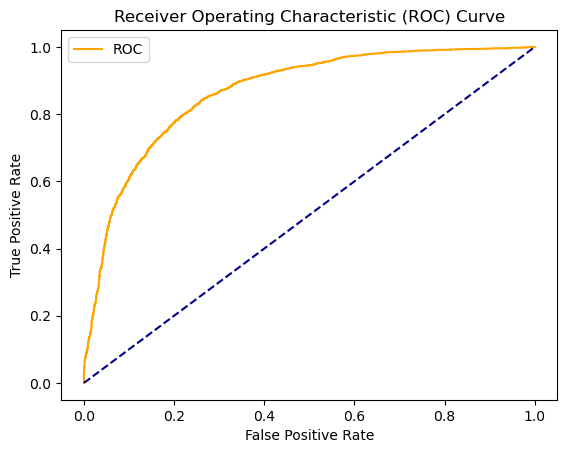

[1 1 1 ... 1 1 0]


In [26]:
# train logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred={}
for i in range(1,m):
    logistic_model = LogisticRegression(max_iter=10000, n_jobs=-1)
    logistic_model.fit(X_train[i], y_train[i])
    y_pred[i] = logistic_model.predict(X_test[i])
    y_pred_prob = logistic_model.predict_proba(X_test[i])[:, 1] #
    if(i==1):
        y_pred_prob_final= y_pred_prob 
        y_pred_final=y_pred[i]
        y_test_final=y_test[i]
    else:
        y_pred_prob_final = np.concatenate((y_pred_prob_final, y_pred_prob))
        y_pred_final = np.concatenate((y_pred_final, y_pred[i]))
        y_test_final = np.concatenate((y_test_final, y_test[i]))
    #print(f'accuracy: {accuracy_score(y_test[i], y_pred[i])*100:.2f}%')
    #print(f'confusion_matrix: \n{confusion_matrix(y_test[i], y_pred[i])}')
    #print(f'classification_report: \n{classification_report(y_test, y_pred)}')
print(f'accuracy: {accuracy_score(y_test_final, y_pred_final)*100:.2f}%')
print(f'confusion_matrix: \n{confusion_matrix(y_test_final, y_pred_final)}')
print(f'classification_report: \n{classification_report(y_test_final, y_pred_final, digits=4)}')
    # show the coefficients
    #print(logistic_model.coef_)

from sklearn.metrics import roc_curve, roc_auc_score

#calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_prob_final) 
# calculate roc_auc_score
roc_auc = roc_auc_score(y_test_final, y_pred_final)
print(f'roc_auc: {roc_auc}')
# plot the roc curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print(y_pred_final)

accuracy: 81.83%
confusion_matrix: 
[[3103  735]
 [ 660 3178]]
classification_report: 
              precision    recall  f1-score   support

           0     0.8246    0.8085    0.8165      3838
           1     0.8122    0.8280    0.8200      3838

    accuracy                         0.8183      7676
   macro avg     0.8184    0.8183    0.8182      7676
weighted avg     0.8184    0.8183    0.8182      7676

roc_auc: 0.818264721208963


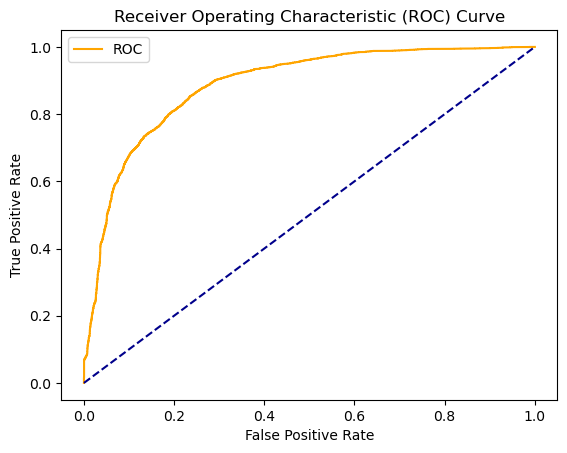

In [32]:
# train random forest model
from sklearn.ensemble import RandomForestClassifier
y_pred={}
for i in range(1,m):
    random_forest_model = RandomForestClassifier(n_jobs=-1, n_estimators=200, max_depth=10)
    random_forest_model.fit(X_train[i], y_train[i])
    y_pred[i] = random_forest_model.predict(X_test[i])
    y_pred_prob = logistic_model.predict_proba(X_test[i])[:, 1]
    if(i==1):
        y_pred_prob_final= y_pred_prob
        y_pred_final=y_pred[i]
        y_test_final=y_test[i]
    else:
        y_pred_prob_final = np.concatenate((y_pred_prob_final, y_pred_prob))
        y_pred_final = np.concatenate((y_pred_final, y_pred[i]))
        y_test_final = np.concatenate((y_test_final, y_test[i]))
    #print(f'accuracy: {accuracy_score(y_test[i], y_pred[i])*100:.2f}%')
    #print(f'confusion_matrix: \n{confusion_matrix(y_test[i], y_pred[i])}')
    #print(f'classification_report: \n{classification_report(y_test, y_pred)}')
print(f'accuracy: {accuracy_score(y_test_final, y_pred_final)*100:.2f}%')
print(f'confusion_matrix: \n{confusion_matrix(y_test_final, y_pred_final)}')
print(f'classification_report: \n{classification_report(y_test_final, y_pred_final, digits=4)}')

fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_prob_final) 
# calculate roc_auc_score
roc_auc = roc_auc_score(y_test_final, y_pred_final)
print(f'roc_auc: {roc_auc}')
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

accuracy: 82.10%
confusion_matrix: 
[[3117  721]
 [ 653 3185]]
classification_report: 
              precision    recall  f1-score   support

           0     0.8268    0.8121    0.8194      3838
           1     0.8154    0.8299    0.8226      3838

    accuracy                         0.8210      7676
   macro avg     0.8211    0.8210    0.8210      7676
weighted avg     0.8211    0.8210    0.8210      7676

roc_auc: 0.8210005211047421


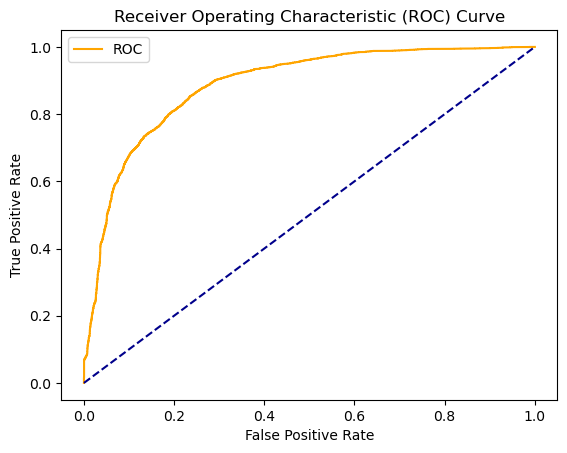

In [33]:
# train xgboost model
from xgboost import XGBClassifier
y_pred={}
for i in range(1,m):
    xgboost_model = XGBClassifier(n_jobs=-1)
    xgboost_model.fit(X_train[i], y_train[i])
    y_pred[i] = xgboost_model.predict(X_test[i])
    y_pred_prob = logistic_model.predict_proba(X_test[i])[:, 1]
    if(i==1):
        y_pred_prob_final= y_pred_prob
        y_pred_final=y_pred[i]
        y_test_final=y_test[i]
    else:
        y_pred_prob_final = np.concatenate((y_pred_prob_final, y_pred_prob))
        y_pred_final = np.concatenate((y_pred_final, y_pred[i]))
        y_test_final = np.concatenate((y_test_final, y_test[i]))
    #print(f'accuracy: {accuracy_score(y_test[i], y_pred[i])*100:.2f}%')
    #print(f'confusion_matrix: \n{confusion_matrix(y_test[i], y_pred[i])}')
    #print(f'classification_report: \n{classification_report(y_test, y_pred)}')
print(f'accuracy: {accuracy_score(y_test_final, y_pred_final)*100:.2f}%')
print(f'confusion_matrix: \n{confusion_matrix(y_test_final, y_pred_final)}')
print(f'classification_report: \n{classification_report(y_test_final, y_pred_final, digits=4)}')

fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_prob_final) 
# calculate roc_auc_score
roc_auc = roc_auc_score(y_test_final, y_pred_final)
print(f'roc_auc: {roc_auc}')
# calculate roc_auc_score
roc_auc = roc_auc_score(y_test_final, y_pred_final)
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()